<img src="https://github.com/pmservice/ai-openscale-tutorials/raw/master/notebooks/images/banner.png" align="left" alt="banner">

# Tutorial on generating an explanation for an image-based model on Watson OpenScale

This notebook includes steps for creating an image-based watson-machine-learning model, creating a subscription, configuring explainability, and finally generating an explanation for a transaction.

### Contents
- [1. Setup](#setup)
- [2. Creating and deploying an image-based model](#deployment)
- [3. Subscriptions](#subscription)
- [4. Explainability](#explainability)

**Note**: If using Watson Studio, try running the notebook on at least 'Default Python 3.5 S' version for faster results (vs Python XS).

<a id="setup"></a>
## 1. Setup

### 1.1 Install Watson OpenScale and WML packages

In [1]:
!pip install --upgrade ibm-ai-openscale
!pip install --upgrade watson-machine-learning-client --no-cache | tail -n 1

# !pip install --upgrade watson-machine-learning-client --no-cache | tail -n 1
# !pip install watson-machine-learning-client==1.0.371

#  !pip install watson-machine-learning-client==1.0.375
# !pip install --upgrade ibm-ai-openscale

# !pip install --upgrade ibm-ai-openscale --no-cache | tail -n 1
# !pip install ibm-ai-openscale==2.1.16

# !pip install --upgrade watson-machine-learning-client --no-cache | tail -n 1
# !pip install watson-machine-learning-client==1.0.371

     |████████████████████████████████| 542kB 15.6MB/s eta 0:00:01


Note: Restart the kernel to assure the new libraries are being used.

### 1.2 Configure credentials

To run this Lab you need to have a valid instance of Watson Openscale.

To verify if you have one, go to the [cloud console](https://cloud.ibm.com/resources), clicking on `Services` you should see your Watson OpenScale instance listed.

if not then from that screen click the upper right button **"Create ressource"**.
From the search entry type 'openscale' and create a lite plan of Watson OpenScale.

You also need a valid **IBM Cloud API Key** to assign the variable in the next cell.

To get it go to the [IBM Cloud console](https://console.bluemix.net/) then click from the upper toolbar `Manage->Access (IAM)`. 
Select `IBM Cloud API Keys` from the left hand sidebar and then click the **"Create an IBM Cloud API Key"** button.

From that page, give your key a name and click Create, then copy the created key and paste it below. 

In [2]:
CLOUD_API_KEY = "<insert your own CLOUD-API-KEY here>"

In [3]:
import requests
from ibm_ai_openscale.utils import get_instance_guid

WOS_GUID = get_instance_guid(api_key=CLOUD_API_KEY)
AIOS_CREDENTIALS = {
    "instance_guid": WOS_GUID,
    "apikey": CLOUD_API_KEY,
    "url": "https://api.aiopenscale.cloud.ibm.com"
}

if WOS_GUID is None:
    print('Watson OpenScale GUID NOT FOUND')
else:
    print(WOS_GUID)

70ee9046-f34e-441c-8dbe-75d57d88b6f7


You also need to have a valid instance of Watson Machine Learning (runtime for your models) running.

To verify if you have one, go to the [cloud console](https://cloud.ibm.com/resources), clicking on `Services` you should see your Watson Machine Learning instance listed.

if not then from that screen click the upper right button **"Create ressource"**.
From the search entry type 'Machine Learning' and create a lite plan of Watson Machine Learning. 
MAKE SURE THE REGION FIELD GOT **DALLAS** as value if not modify it accordingly.

From the IBM Cloud Resource list click on the Watson Machine Learning instance and from this page click the service credentials side bar item.
clik on view **'credentials'** and copy the all json info provided as follow :

```
{
  "apikey": "XXXXXXXXXX",
  "iam_apikey_description": "Auto-generated for key XXXX-YYYYY-ZZZZZZ",
  "iam_apikey_name": "WML-credentials",
  "iam_role_crn": "crn:v1:bluemix:public:iam::::serviceRole:Writer",
  "iam_serviceid_crn": "crn:v1:bluemix:public:iam-identity::a/XXXXXXXX::serviceid:ServiceId-XXXX-YYYYYY-ZZZZZZZZ",
  "instance_id": "WWWWWWWWWWWWWWWW",
  "url": "https://us-south.ml.cloud.ibm.com"
}
```   
    

replace the following variable with the obtained json data.

In [4]:

WML_CREDENTIALS = {
  "apikey": "xxxxxxxxxxxxxx",
  "iam_apikey_description": "Auto-generated for key yyyyyyyyyyyyy",
  "iam_apikey_name": "Service credentials-WML4JLC",
  "iam_role_crn": "crn:v1:bluemix:public:iam::::serviceRole:Writer",zzzzz",
  "instance_id": "xxxxxxx",
  "url": "https://us-south.ml.cloud.ibm.com"
}

In [5]:
import sys, time

def Wait(seconds, Speed=5):
    Chars = ["|","/","-","\\"]
    MaxChars = 4
    sys.stdout.flush()
    for i in range(seconds*Speed):
        sys.stdout.write("\r" + Chars[i % MaxChars])
        sys.stdout.flush()
        time.sleep(1/Speed)
    sys.stdout.write("\r ")
Wait(10)

<a id="deployment"></a>
## 2. Creating and deploying an image-based model

The dataset used is MNIST dataset of handwritten digits. It consists of 60,000 28x28 grayscale images of the 10 digits, along with a test set of 10,000 images. More information about the dataset can be found here: https://keras.io/datasets/#mnist-database-of-handwritten-digits

Note: Tensorflow versions supported by WML are: 1.2, 1.5, and 1.11. Make sure you have one of these versions before creating the models. Version 1.11 is used in this notebook.

### 2.1 Creating a model

In [6]:
!pip install keras
!pip install tensorflow==1.11.0
!pip install keras_sequential_ascii

import keras
from keras.datasets import mnist
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D
from keras_sequential_ascii import sequential_model_to_ascii_printout
from keras import backend as keras_backend

     |████████████████████████████████| 63.0MB 45.6MB/s eta 0:00:01
     |████████████████████████████████| 3.0MB 39.7MB/s eta 0:00:01:01�█████████████▏ | 2.9MB 39.7MB/s eta 0:00:01
     |████████████████████████████████| 573kB 37.4MB/s eta 0:00:01
  Found existing installation: setuptools 40.8.0
    Uninstalling setuptools-40.8.0:
      Successfully uninstalled setuptools-40.8.0
  Found existing installation: tensorflow 1.13.1
    Uninstalling tensorflow-1.13.1:
      Successfully uninstalled tensorflow-1.13.1
  Stored in directory: /home/dsxuser/.cache/pip/wheels/f5/8d/81/912666dff82a923ce423a7e797cd75f54271c7031512cdb282
Successfully built keras-sequential-ascii


Using TensorFlow backend.


In [7]:
print("KERAS v {}".format(keras.__version__))

import tensorflow as tf
print("TENSORFLOW v {}".format(tf.__version__))

KERAS v 2.2.4
TENSORFLOW v 1.11.0


In [8]:
!ls

In [9]:
batch_size = 128
num_classes = 10
epochs = 5

In [10]:
# input image dimensions
img_rows, img_cols = 28, 28

# the data, split between train and test sets
(x_train, y_train), (x_test, y_test) = mnist.load_data()

if keras_backend.image_data_format() == 'channels_first':
    x_train = x_train.reshape(x_train.shape[0], 1, img_rows, img_cols)
    x_test = x_test.reshape(x_test.shape[0], 1, img_rows, img_cols)
    input_shape = (1, img_rows, img_cols)
else:
    x_train = x_train.reshape(x_train.shape[0], img_rows, img_cols, 1)
    x_test = x_test.reshape(x_test.shape[0], img_rows, img_cols, 1)
    input_shape = (img_rows, img_cols, 1)

x_train = x_train.astype('float32')
x_test = x_test.astype('float32')
x_train /= 255
x_test /= 255

print('x_train shape:', x_train.shape)
print(x_train.shape[0], 'train samples')
print(x_test.shape[0], 'test samples')

11493376/11490434 [==============================] - 0s 0us/step
x_train shape: (60000, 28, 28, 1)
60000 train samples
10000 test samples


In [11]:
# convert class vectors to binary class matrices
y_train = keras.utils.to_categorical(y_train, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)

if you don't want to train the model during this lab, which is quite time consumming (15 mn average) depending on the size of your python/jupyter environment, you can use a pre-trained model provided to you with this notebook file.
You also have the definition and trained weights of the model in a file called **HandWrittenDigit-CNN.h5**

**Keras also supports a simpler interface to save both the model weights and model architecture together into a single H5 file, 
while the HDF5 format store only Model weights and therefore the model architecture is provided as a JSON format.**
    
* Saving/Loading the model in H5 includes everything we need to know about the model, including:
    - Model weights.
    - Model architecture.
    - Model compilation details (loss and metrics).
    - Model optimizer state.
* This means that we can load and use the model directly, without having to re-compile it.


To upload the HD5 file and use it please procedd as follow :

From the upper toolbar select the *01* icon and Files tab, then drag/drop the file **HandWrittenDigit-CNN.h5** provided in the box folder

Therefore the file appears in the right hand side bar.

Move your cursor on the cell bellow and remove everything (cell fully empty !)

Once done click the drop down arrow of the right hand side window where **HandWrittenDigit-CNN.h5** is and select **insert to code>>Insert Streaming Object**

the equivalent of the following should appear with your own project COS credentials

```
import types
import pandas as pd
from botocore.client import Config
import ibm_boto3

def __iter__(self): return 0

# @hidden_cell
# The following code accesses a file in your IBM Cloud Object Storage. It includes your credentials.
# You might want to remove those credentials before you share the notebook.
client_8a2a8e9ef5a44a08aaca7ec89672ecaa = ibm_boto3.client(service_name='s3',
    ibm_api_key_id='xxxxxxxxxxxxx',
    ibm_auth_endpoint="https://iam.ng.bluemix.net/oidc/token",
    config=Config(signature_version='oauth'),
    endpoint_url='https://s3-api.us-geo.objectstorage.service.networklayer.com')

# Your data file was loaded into a botocore.response.StreamingBody object.
# Please read the documentation of ibm_boto3 and pandas to learn more about the possibilities to load the data.
# ibm_boto3 documentation: https://ibm.github.io/ibm-cos-sdk-python/
# pandas documentation: http://pandas.pydata.org/
streaming_body_1 = client_8a2a8e9ef5a44a08aaca7ec89672ecaa.get_object(Bucket='XXXXXXX', Key='HandWrittenDigit-CNN.h5')['Body']
# add missing __iter__ method, so pandas accepts body as file-like object
if not hasattr(streaming_body_1, "__iter__"): streaming_body_1.__iter__ = types.MethodType( __iter__, streaming_body_1 ) 

```   

You also need to retrieve the bucket name of you Cloud Object Storage (COS) from the inserted code and then insert it into the cell where you will need to download files from the COS (see sample below)

client_xxxxxxxx.get_object(<span style="background-color: #FFFF00"> Bucket='my-generated-bucket-name-123245566788' </span>, Key='HandWrittenDigit-CNN.h5')['Body']

```
client_COS.download_file(Bucket='<inset your bucket-name here>',Key='HandWrittenDigit-CNN.h5',Filename='HandWrittenDigit-CNN.h5')

```

Last but not least rename the variable called **'client_8a2a8e9ef......72ecaa'** with **client_COS** (a bit more clear and reusable for the rest of the notebook !


You're now ready to usethe HD5 definition and weights for your model instead of having to retrain it.

In [12]:
import types
import pandas as pd
from botocore.client import Config
import ibm_boto3

def __iter__(self): return 0

# @hidden_cell
# The following code accesses a file in your IBM Cloud Object Storage. It includes your credentials.
# You might want to remove those credentials before you share the notebook.
client_8a2a8e9ef5a44a08aaca7ec89672ecaa = ibm_boto3.client(service_name='s3',
    ibm_api_key_id='SgL3gHSfOX7WRMxOLrrvDiDvOl8Z0aCkeMIL9S3j-9Ge',
    ibm_auth_endpoint="https://iam.ng.bluemix.net/oidc/token",
    config=Config(signature_version='oauth'),
    endpoint_url='https://s3-api.us-geo.objectstorage.service.networklayer.com')

# Your data file was loaded into a botocore.response.StreamingBody object.
# Please read the documentation of ibm_boto3 and pandas to learn more about the possibilities to load the data.
# ibm_boto3 documentation: https://ibm.github.io/ibm-cos-sdk-python/
# pandas documentation: http://pandas.pydata.org/
streaming_body_1 = client_8a2a8e9ef5a44a08aaca7ec89672ecaa.get_object(Bucket='demoai-donotdelete-pr-odc7lk3sakuluh', Key='_mini_XCEPTION.102-0.66.hdf5')['Body']
# add missing __iter__ method, so pandas accepts body as file-like object
if not hasattr(streaming_body_1, "__iter__"): streaming_body_1.__iter__ = types.MethodType( __iter__, streaming_body_1 ) 


In [13]:
Client_COS = client_8a2a8e9ef5a44a08aaca7ec89672ecaa

In [14]:
ModelFile = 'HandWrittenDigit-CNN.h5'

ReTrainModel = 5
try:
    # Replace the below bucket name by your own bucket project name.    
    Client_COS.download_file(Bucket='demoai-donotdelete-pr-odc7lk3sakuluh', Key=ModelFile,Filename=ModelFile)
except:
    # Model never created tbd
    RetrainModel = 1
else:
    RetrainModel = 0
print("Model to be retrain : ", RetrainModel)
!ls

Model to be retrain :  0
HandWrittenDigit-CNN.h5


In [15]:
# Define Model

def base_model():
    model = Sequential()
    model.add(Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape=input_shape))
    model.add(Conv2D(64, (3, 3), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.25))
    model.add(Flatten())
    model.add(Dense(128, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(num_classes, activation='softmax'))

    model.compile(loss=keras.losses.categorical_crossentropy,
                  optimizer=keras.optimizers.Adadelta(),
                  metrics=['accuracy'])
    return model

In [16]:
from keras.models import load_model

if RetrainModel == 0:
    cnn_n = load_model(ModelFile)
    cnn_n.compile(optimizer='adam', loss='categorical_crossentropy')
else:
    cnn_n = base_model()

cnn_n.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 26, 26, 32)        320       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 24, 24, 64)        18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 12, 12, 64)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 12, 12, 64)        0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 9216)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 128)               1179776   
_________________________________________________________________
dropout_2 (Dropout)          (None, 128)               0         
__________

In [17]:
# Vizualizing model structure
sequential_model_to_ascii_printout(cnn_n)

           OPERATION           DATA DIMENSIONS   WEIGHTS(N)   WEIGHTS(%)

               Input   #####     28   28    1
              Conv2D    \|/  -------------------       320     0.0%
                relu   #####     26   26   32
              Conv2D    \|/  -------------------     18496     1.5%
                relu   #####     24   24   64
        MaxPooling2D   Y max -------------------         0     0.0%
                       #####     12   12   64
             Dropout    | || -------------------         0     0.0%
                       #####     12   12   64
             Flatten   ||||| -------------------         0     0.0%
                       #####        9216
               Dense   XXXXX -------------------   1179776    98.3%
                relu   #####         128
             Dropout    | || -------------------         0     0.0%
                       #####         128
               Dense   XXXXX -------------------      1290     0.1%
             softmax   ##### 

In [18]:
# Fit model
print(y_train.shape)
if RetrainModel == 1:
    cnn = cnn_n.fit(x_train, y_train, batch_size=batch_size, epochs=epochs, validation_data=(x_test, y_test))

(60000, 10)


In [19]:
if RetrainModel == 1:
    scores = cnn_n.evaluate(x_test, y_test, verbose=0)
    print(scores)
    print("Accuracy: %.2f%%" % (scores[1]*100))

In [20]:
if RetrainModel == 1:
    cnn_n.save(ModelFile)
    ClientCOS.upload_file(Bucket='demoai-donotdelete-pr-odc7lk3sakuluh', Key=ModelFile,Filename=ModelFile)

### 2.2 Storing the model

In [21]:
from watson_machine_learning_client import WatsonMachineLearningAPIClient

wml_client = WatsonMachineLearningAPIClient(WML_CREDENTIALS)

In [22]:
cnn_n.save("mnist_cnn.h5")
!rm mnist_cnn.tar*
!tar -czvf mnist_cnn.tar.gz mnist_cnn.h5

rm: cannot remove ‘mnist_cnn.tar*’: No such file or directory
mnist_cnn.h5


In [23]:
!rm mnist_cnn.h5

In [24]:
model_name = "MNIST Model"

# Update the FRAMEWORK_VERSION below depending on the tensorflow version used
model_meta = {
    wml_client.repository.ModelMetaNames.NAME: model_name,
    wml_client.repository.ModelMetaNames.DESCRIPTION: "MNIST model",
    wml_client.repository.ModelMetaNames.FRAMEWORK_NAME: "tensorflow",
    wml_client.repository.ModelMetaNames.FRAMEWORK_VERSION: "1.11",
    wml_client.repository.ModelMetaNames.FRAMEWORK_LIBRARIES: [
         {"name": "keras", "version": "2.2.4"}
    ]
}

In [25]:
 wml_client.repository.list()
# wml_client.repository.delete('')
# wml_client.deployments.delete('')

------------------------------------  -------------------------------  ------------------------  ---------------  -----------------
GUID                                  NAME                             CREATED                   FRAMEWORK        TYPE
13bc8f83-ec48-41e5-ba28-dee6154e2080  Spark German Risk Model - Final  2019-11-08T10:03:42.944Z  mllib            definition
91e232a5-0bc8-4916-81f7-19be81aa33bf  Spark German Risk Model - Final  2019-10-02T10:13:10.364Z  mllib            definition
812f030f-56c7-4231-a24e-0d0ed9fb917c  Spark German Risk Model - Final  2019-09-30T19:39:32.021Z  mllib            definition
85c80a15-a03e-45b6-904d-806a291e260a  Spark German Risk Model - Final  2019-09-30T17:51:50.181Z  mllib            definition
60d3a487-1f32-4fd4-9a49-7ea85001306d  Spark German Risk Model - Final  2019-09-30T17:50:29.777Z  mllib            definition
35a9ed96-fc11-4129-9a96-f83f71020694  Spark German Risk Model - Final  2019-09-30T17:46:37.635Z  mllib            definition

In [26]:
# published_model_details = wml_client.repository.get_details('7d7d20b6-6e54-4643-ae14-f99f41f0f986')

In [27]:
published_model_details = wml_client.repository.store_model(model='mnist_cnn.tar.gz', meta_props=model_meta)

Note: Model of framework tensorflow and versions 1.5/1.11 has been deprecated. These versions will not be supported after 26th Nov 2019.


In [28]:
model_uid = wml_client.repository.get_model_uid(published_model_details)
model_uid 

'0350bda8-6d1a-4763-a0a4-9c7070527ad7'

### 2.3 Deploying the model

In [29]:
deployment= wml_client.deployments.create(name= model_name + " Deployment", model_uid=model_uid)

Note: Model of framework tensorflow and versions 1.5/1.11 has been deprecated. These versions will not be supported after 26th Nov 2019.


#######################################################################################

Synchronous deployment creation for uid: '0350bda8-6d1a-4763-a0a4-9c7070527ad7' started

#######################################################################################


INITIALIZING
DEPLOY_IN_PROGRESS..
DEPLOY_SUCCESS


------------------------------------------------------------------------------------------------
Successfully finished deployment creation, deployment_uid='eb5b0436-a33a-4297-92db-8a2d3126ee86'
------------------------------------------------------------------------------------------------




In [30]:
scoring_url = wml_client.deployments.get_scoring_url(deployment)
print(scoring_url)

https://us-south.ml.cloud.ibm.com/v3/wml_instances/febb80c2-33af-4014-8dd8-ef2170ff4cfb/deployments/eb5b0436-a33a-4297-92db-8a2d3126ee86/online


## 3. Subscriptions

### 3.1 Configuring OpenScale

In [31]:
from ibm_ai_openscale import APIClient
from ibm_ai_openscale.engines import WatsonMachineLearningAsset

aios_client = APIClient(AIOS_CREDENTIALS)
aios_client.version

'2.1.17'

In [32]:
#  CLEAN SUBSCRIPTION ENTRIES
subscriptions_uids = aios_client.data_mart.subscriptions.get_uids()
for subscription in subscriptions_uids:
    sub_name = aios_client.data_mart.subscriptions.get_details(subscription)['entity']['asset']['name']
    if sub_name == model_name:
        aios_client.data_mart.subscriptions.delete(subscription)
        print('Deleted existing subscription for', model_name)

Deleted existing subscription for MNIST Model


### 3.2 Subscribe the asset

In [33]:
from ibm_ai_openscale.supporting_classes import *

aios_client.data_mart.subscriptions.list()
# aios_client.data_mart.subscriptions.delete('657c48a9-d29a-4e29-a215-b8a28046bfd3')

Asset = WatsonMachineLearningAsset(model_uid,
                                   problem_type=ProblemType.MULTICLASS_CLASSIFICATION,
                                   input_data_type=InputDataType.UNSTRUCTURED_IMAGE,
                                   probability_column='probability'
                                  )
subscription = aios_client.data_mart.subscriptions.add(Asset)

ba8e4e44-5b90-459d-9aa8-fe04631e15e4,FER-Model-HDF5,model,febb80c2-33af-4014-8dd8-ef2170ff4cfb,2019-11-11T15:26:14.501Z
087a04a9-2318-472e-ad42-3783b631666b,Spark German Risk Model - Final,model,febb80c2-33af-4014-8dd8-ef2170ff4cfb,2019-11-08T10:04:43.254Z
b5079da2-264b-43e8-a71f-a9ee23208832,FER-Kaggle,model,febb80c2-33af-4014-8dd8-ef2170ff4cfb,2019-10-16T11:26:28.635Z
c50ada6b-a76e-42be-b000-831d519dda63,FER-2013,model,febb80c2-33af-4014-8dd8-ef2170ff4cfb,2019-10-09T22:18:02.029Z


In [34]:
aios_client.data_mart.subscriptions.list()

e56ffa07-970d-4d74-b284-1e1e03244544,MNIST Model,model,febb80c2-33af-4014-8dd8-ef2170ff4cfb,2019-11-12T14:14:59.425Z
ba8e4e44-5b90-459d-9aa8-fe04631e15e4,FER-Model-HDF5,model,febb80c2-33af-4014-8dd8-ef2170ff4cfb,2019-11-11T15:26:14.501Z
087a04a9-2318-472e-ad42-3783b631666b,Spark German Risk Model - Final,model,febb80c2-33af-4014-8dd8-ef2170ff4cfb,2019-11-08T10:04:43.254Z
b5079da2-264b-43e8-a71f-a9ee23208832,FER-Kaggle,model,febb80c2-33af-4014-8dd8-ef2170ff4cfb,2019-10-16T11:26:28.635Z
c50ada6b-a76e-42be-b000-831d519dda63,FER-2013,model,febb80c2-33af-4014-8dd8-ef2170ff4cfb,2019-10-09T22:18:02.029Z


In [35]:
subscription.get_details()

{'entity': {'asset': {'asset_id': '0350bda8-6d1a-4763-a0a4-9c7070527ad7',
   'asset_type': 'model',
   'created_at': '2019-11-12T14:14:22.580Z',
   'name': 'MNIST Model',
   'url': 'https://us-south.ml.cloud.ibm.com/v3/wml_instances/febb80c2-33af-4014-8dd8-ef2170ff4cfb/published_models/0350bda8-6d1a-4763-a0a4-9c7070527ad7'},
  'asset_properties': {'input_data_type': 'unstructured_image',
   'model_type': 'tensorflow-1.11',
   'probability_fields': ['probability'],
   'problem_type': 'multiclass',
   'runtime_environment': 'None Provided'},
  'configurations': [{'enabled': True,
    'monitor_definition_id': 'payload_logging',
    'type': 'payload_logging',
    'url': '/v1/data_marts/70ee9046-f34e-441c-8dbe-75d57d88b6f7/service_bindings/febb80c2-33af-4014-8dd8-ef2170ff4cfb/subscriptions/e56ffa07-970d-4d74-b284-1e1e03244544/configurations/payload_logging'},
   {'enabled': False,
    'monitor_definition_id': 'explainability',
    'type': 'explainability',
    'url': '/v1/data_marts/70ee904

### 3.3 Score the model and get transaction-id

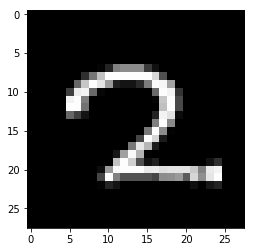

In [36]:
!pip install numpy
!pip install matplotlib

import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline 
img = np.array(x_test[77], dtype='float')
pixels = img.reshape((28, 28))
plt.imshow(pixels, cmap='gray')
plt.show()

In [39]:
import json

Wait(20)

scoring_data = {'values': [x_test[77].tolist()]}
predictions = wml_client.deployments.score(scoring_url, scoring_data)
print(json.dumps(predictions, sort_keys=True, indent=4))

 {
    "fields": [
        "prediction",
        "prediction_classes",
        "probability"
    ],
    "values": [
        [
            [
                3.840007047983818e-05,
                3.6366909625940025e-06,
                0.9999328851699829,
                1.4511347501411365e-07,
                2.573256274729374e-09,
                3.4113309399508296e-10,
                3.763992673100347e-09,
                2.2245205400395207e-05,
                2.4453431706206175e-06,
                2.6317934498365503e-07
            ],
            2,
            [
                3.840007047983818e-05,
                3.6366909625940025e-06,
                0.9999328851699829,
                1.4511347501411365e-07,
                2.573256274729374e-09,
                3.4113309399508296e-10,
                3.763992673100347e-09,
                2.2245205400395207e-05,
                2.4453431706206175e-06,
                2.6317934498365503e-07
            ]
        ]
    ]
}


In [40]:
Wait(20)
transaction_id = subscription.payload_logging.get_table_content().scoring_id[0]
transaction_id

'648e088bab6e54d81303cc1744a03233-1'

<a id="explainability"></a>
## 4. Explainability

### 4.1 Configure Explainability

In [41]:
subscription.explainability.enable()

In [42]:
subscription.explainability.get_details()

{'enabled': True}

### 4.2 Get explanation for the transaction

In [43]:
explanation = ()
try :
    explanation = subscription.explainability.run(transaction_id, background_mode=False,cem=False)
except:
  print("Something went wrong")
  wml_client.repository.delete(model_uid)
  deployment_id = wml_client.deployments.get_uid(deployment)
  wml_client.deployments.delete(deployment_id)




 Looking for explanation for 648e088bab6e54d81303cc1744a03233-1 




in_progress.........
finishedSomething went wrong
{"trace":"c0de5ec42ececc4981bd7cd3a9c13a76","errors":[{"code":"not_found","message":"Requested object could not be found."}]}


If you get an error in the preious cell
something ending by **KeyError: 'cem_state'**
it's a bug :( in the library, but still you can collect the transaction_id from the upper cell

```
# Wait(60)
transaction_id = subscription.payload_logging.get_table_content().scoring_id[0]
transaction_id
```

then open the following webpage and paste the transaction_id and search for it, you will see the result of the image model explainability.

https://aiopenscale.cloud.ibm.com/aiopenscale/explain

    
**Explaining image model transactions**

For an image classification model example of explainability, you can see which parts of an image contributed positively to the predicted outcome and which contributed negatively. In the following example, the image in the positive pane shows the parts which impacted positively to the prediction and the image in the negative pane shows the parts of images that had a negative impact on the outcome.

In [ ]:
import json
print (json.dumps(explanation,  sort_keys=True, indent=4))

### The explanation images can be obtained using the cells below

In [ ]:
!pip install Pillow
from PIL import Image
import base64
import io

imgOrigin = explanation["entity"]["predictions"][0]["explanation_features"][0]["full_image"]
img_data = base64.b64decode(imgOrigin)
OriginPic = Image.open(io.BytesIO(img_data)).resize((128, 128)).convert('RGBA')

In [ ]:
img = explanation["entity"]["predictions"][1]["explanation_features"][0]["full_image"]
img_data = base64.b64decode(img)
ExpPic = Image.open(io.BytesIO(img_data)).resize((128, 128))

In [ ]:
Background = ExpPic.convert('RGBA')

# "data" is a height x width x 4 numpy array
data = np.array(Background)

# Temporarily unpack the bands for readability
red, green, blue, alpha = data.T 

# Replace white with red... (leaves alpha values alone...)
white_areas = (red != 0) | (blue != 0) | (green != 0)
data[..., :-1][white_areas.T] = (255, 0, 0) # Transpose back needed

Background = Image.fromarray(data)

In [ ]:
Image.blend(Background, OriginPic,alpha=0.3).resize((256,256))

In [ ]:
wml_client.repository.delete(model_uid)
deployment_id = wml_client.deployments.get_uid(deployment)
wml_client.deployments.delete(deployment_id)